In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --no-warn-script-location --user tensorflow

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# file import and read - dataset 1
#==================================
#df = pd.read_csv(r"C:\Users\Shylu\Desktop\MS prep\2nd sem\ML\Assignment1\sgemm_product_dataset\sgemm_product.csv")
df_sgemm = pd.read_csv("sgemm_product.csv")
df_sgemm.describe()

# generate target variable as average of runs
df_sgemm['y']=(df_sgemm['Run1 (ms)']+df_sgemm['Run2 (ms)']+df_sgemm['Run3 (ms)']+df_sgemm['Run4 (ms)'])/4

#print(df['y'])
# remove extra fields in data set
df_sgemm.drop(['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)'], axis=1, inplace=True)


In [3]:
# remove outliers above or below 3 standard deviations from mean
#=================================================================

df_sgemm = df_sgemm[~(np.abs(df_sgemm['y']-df_sgemm['y'].mean()) > (3*df_sgemm['y'].std()))] 
df_sgemm_orig = df_sgemm.copy()
df_sgemm

#236349 rows 

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,y
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.4525


In [4]:
# convert y to logistic
#========================
# df_sgemm['y'].mean()  = 175.549
#(df_sgemm['y'].apply(lambda x: 1 if x>175 else 0 ) ).sum() = 69707

cut_off = round(df_sgemm['y'].mean())
df_sgemm['y'] = df_sgemm['y'].apply(lambda x: 1 if x>cut_off else 0 ) 

# normalize dataset
#======================

cols_to_norm = ['MWG','NWG', 'KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']
df_sgemm[cols_to_norm] = StandardScaler().fit_transform(df_sgemm[cols_to_norm])
df_sgemm

df_sgemm

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,y
0,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,0,0,0
1,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,0,1,0
2,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,1,0,0
3,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,1,1,0
4,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,0,1,1,0
241596,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,1,0,0,0
241597,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,1,0,1,0
241598,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,1,1,0,0


In [5]:
# split into train and test data set (70/30)
sgemm_train, sgemm_test = train_test_split(df_sgemm,train_size=0.7, test_size=0.3, random_state=0)

print(len(sgemm_train))
print(len(sgemm_test))

165444
70905


In [6]:
# file import and read - dataset 2
#==================================
#df = pd.read_csv(r"C:\Users\Shylu\Desktop\MS prep\2nd sem\ML\Assignment1\sgemm_product_dataset\sgemm_product.csv")
df_mush = pd.read_csv("mushrooms.csv")
print(df_mush.describe())

df_mush

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top    

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [7]:
#imputing missing stalk-root values with most frequent value
#=============================================================

missing = (df_mush['stalk-root'].apply(lambda x:1 if x=='?' else 0)).sum()
print(missing)
print(df_mush['stalk-root'].value_counts())

df_mush = df_mush.replace('?',np.NaN)
print((df_mush['stalk-root'].isnull()).sum())

df_mush = df_mush.apply(lambda x: x.fillna(x.value_counts().index[0]))
#df_mush

print(df_mush['stalk-root'].value_counts())
print((df_mush['stalk-root'].isnull()).sum())

2480
b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
2480
b    6256
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
0


In [8]:
#converting binary value columns into 0 and 1

df_mush['class'] = df_mush['class'].apply(lambda x: 1 if x=='p' else 0)
df_mush['bruises'] = df_mush['bruises'].apply(lambda x: 1 if x=='t' else 0)
df_mush['gill-attachment'] = df_mush['gill-attachment'].apply(lambda x: 1 if x=='a' else 0)
df_mush['gill-spacing'] = df_mush['gill-spacing'].apply(lambda x: 1 if x=='c' else 0)
df_mush['gill-size'] = df_mush['gill-size'].apply(lambda x: 1 if x=='b' else 0)
df_mush['stalk-shape'] = df_mush['stalk-shape'].apply(lambda x: 1 if x=='e' else 0)
df_mush['veil-type'] = df_mush['veil-type'].apply(lambda x: 1 if x=='p' else 0)

df_mush

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,1,p,0,1,0,k,...,s,w,w,1,w,o,p,k,s,u
1,0,x,s,y,1,a,0,1,1,k,...,s,w,w,1,w,o,p,n,n,g
2,0,b,s,w,1,l,0,1,1,n,...,s,w,w,1,w,o,p,n,n,m
3,1,x,y,w,1,p,0,1,0,n,...,s,w,w,1,w,o,p,k,s,u
4,0,x,s,g,0,n,0,0,1,k,...,s,w,w,1,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,k,s,n,0,n,1,1,1,y,...,s,o,o,1,o,o,p,b,c,l
8120,0,x,s,n,0,n,1,1,1,y,...,s,o,o,1,n,o,p,b,v,l
8121,0,f,s,n,0,n,1,1,1,n,...,s,o,o,1,o,o,p,b,c,l
8122,1,k,y,n,0,y,0,1,0,b,...,k,w,w,1,w,o,e,w,v,l


In [9]:
#columns with more than 2 values. Split and pivot them
df_mush_trans = pd.get_dummies(df_mush, prefix=['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color','stalk-root', 
                                            'stalk-surface-above-ring','stalk-surface-below-ring', 'stalk-color-above-ring',
                                            'stalk-color-below-ring', 'veil-color', 'ring-number','ring-type', 
                                            'spore-print-color', 'population', 'habitat'])
df_mush_trans

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,veil-type,cap-shape_b,cap-shape_c,cap-shape_f,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,1,1,1,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8121,0,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8122,1,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [10]:
# split into train and test data set (70/30)
mush_train, mush_test = train_test_split(df_mush_trans,train_size=0.7, test_size=0.3, random_state=0)

print(len(mush_train))
print(len(mush_test))

5686
2438


In [34]:
def ann(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, nhidlayer, nneuron, activ_hidden,active_outer,hidlayerneuron):  
    model = Sequential()

    # 1st layer = input layer dimensions = no.of input cols
    # 2nd layer = 1st hidden layer = 11 neurons - assuming ((2/3)*(no.of input layer neurons))+no.of output layer neurons
    if hidlayerneuron==0:
        n_hidden_neuron = math.ceil(((2/3)*nneuron)+1)
    else: #user-defined number of hidden layer neurons
        n_hidden_neuron=hidlayerneuron
        
    print("No.of neurons in 1st hidden layer: {0}".format(n_hidden_neuron))
    model.add(Dense(n_hidden_neuron, input_dim=xtrain_train.shape[1], activation=activ_hidden)) 
    
    #adding subsequent hidden layers
    if nhidlayer>1:
        for i in range(1,nhidlayer):
            if hidlayerneuron==0:
                n_hidden_neuron=math.ceil(((2/3)*n_hidden_neuron)+1) #((2/3)*(no.of input layer neurons))+no.of output layer neurons
                print("No.of neurons in hidden layer {0}: {1}".format(i+1,n_hidden_neuron))
                model.add(Dense(n_hidden_neuron, activation=activ_hidden))  
            else: #user-defined number of hidden layer neurons
                n_hidden_neuron=hidlayerneuron #((2/3)*(no.of input layer neurons))+no.of output layer neurons
                print("No.of neurons in hidden layer {0}: {1}".format(i+1,n_hidden_neuron))
                model.add(Dense(n_hidden_neuron, activation=activ_hidden))   
                

    #output layer
    model.add(Dense(1, activation=active_outer)) 
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    model.fit(xtrain_train, ytrain_train, epochs=75, batch_size=20, verbose = 0) #, verbose = 1
    
    y_pred_in_sample = model.predict(xtrain_test) 
    y_pred_in_sample = y_pred_in_sample>0.5
    print ("In sample confusion matrix:")
    print(confusion_matrix(ytrain_test, y_pred_in_sample))
    
    y_pred_out_of_sample = model.predict(xtest_test)
    y_pred_out_of_sample = y_pred_out_of_sample>0.5
    print ("Out of sample confusion matrix:")
    print(confusion_matrix(ytest_test, y_pred_out_of_sample))
    
    _, accuracy_in_sample = model.evaluate(xtrain_test, ytrain_test, verbose=1)
    print('In Sample Accuracy: %.2f' % (accuracy_in_sample))  
    
    _, accuracy_out_sample = model.evaluate(xtest_test, ytest_test, verbose=1)
    print('Out of Sample Accuracy: %.2f' % (accuracy_out_sample))    

    return accuracy_in_sample, accuracy_out_sample
      
    

In [12]:
def perf_tune_sgemm(optimizer='adam',learn_rate=0.01, momentum=0, activation='relu'):
    model = Sequential()
    model.add(Dense(11, input_dim=len(sgemm_train_x.columns), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])    
    return model

In [30]:
def perf_tune_mush(optimizer='adam',learn_rate=0.01, momentum=0, activation='relu'):
    model = Sequential()
    model.add(Dense(75, input_dim=len(mush_train_x.columns), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])    
    return model

In [33]:
def knn(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,neighbor, dist_metric):
    knn = KNeighborsClassifier(n_neighbors=neighbor, metric=dist_metric) 
    knn.fit(xtrain_train, ytrain_train) 
  
    # Predict 
    y_pred_in_sample = knn.predict(xtrain_test) 
    print ("In sample confusion matrix:")
    print(confusion_matrix(ytrain_test, y_pred_in_sample))
    
    y_pred_out_of_sample = knn.predict(xtest_test)
    print ("Out of sample confusion matrix:")
    print(confusion_matrix(ytest_test, y_pred_out_of_sample))
    
    accuracy_in_sample = metrics.accuracy_score(ytrain_test, y_pred_in_sample)
    accuracy_out_sample = metrics.accuracy_score(ytest_test, y_pred_out_of_sample)
    
   # _, accuracy_in_sample = knn.score(xtrain_test, ytrain_test.ravel())
    print('In Sample Accuracy: %.2f' % (accuracy_in_sample))  
    
   # _, accuracy_out_sample = knn.score(xtest_test, ytest_test.ravel())
    print('Out of Sample Accuracy: %.2f' % (accuracy_out_sample))    

    return accuracy_in_sample, accuracy_out_sample
    

In [35]:
# cross validation
#==================
def cross_validation(xtrain,ytrain,xtest,ytest,fn_id,nfold=4,nhidlayer=1,nneuron=15, activ_hidden='relu',active_outer='sigmoid', hidlayerneuron=0, neighbor=3, dist_metric='euclidean'):
    k=nfold
    i=0
    n_train=xtrain.shape[0]
    n_test=xtest.shape[0]
    accuracy_train= []
    accuracy_test = []
    
    for i in range(k):
        print("Cross validation iteration : {0}".format(i+1))
        xtrain_test = xtrain[int(i*n_train/k):int((i+1)*n_train/k)]
        ytrain_test = ytrain[int(i*n_train/k):int((i+1)*n_train/k)]
        xtest_test = xtest[int(i*n_test/k):int((i+1)*n_test/k)]
        ytest_test = ytest[int(i*n_test/k):int((i+1)*n_test/k)]
        
        xtrain_train_lower = xtrain[:int(i*n_train/k)]
        ytrain_train_lower = ytrain[:int(i*n_train/k)]

        xtrain_train_upper = xtrain[int((i+1)*n_train/k):]
        ytrain_train_upper = ytrain[int((i+1)*n_train/k):]
                
        xtrain_train = np.concatenate((xtrain_train_lower,xtrain_train_upper))
        ytrain_train = np.concatenate((ytrain_train_lower,ytrain_train_upper))
        
        if fn_id==1:  # ann
            acc_train, acc_test = ann(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,nhidlayer,nneuron,'relu','sigmoid',hidlayerneuron)
        
        elif fn_id==2:  #knn
            acc_train, acc_test = knn(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,neighbor, dist_metric)
         
        accuracy_train.append(acc_train)
        accuracy_test.append(acc_test)
            
    return accuracy_train, accuracy_test #, cnf_matrix_train, cnf_matrix_test


In [16]:
# Dataset 1 = sgemm product 
#===========================
sgemm_train_x = sgemm_train[sgemm_train.columns.difference(['y'])]  # take all other columns except y
sgemm_train_y = sgemm_train['y']
sgemm_test_x = sgemm_test[sgemm_test.columns.difference(['y'])] 
sgemm_test_y = sgemm_test['y']

# Dataset 2 = mushroom
#======================
mush_train_x = mush_train[mush_train.columns.difference(['class'])]  # take all other columns except class
mush_train_y = mush_train['class']
mush_test_x = mush_test[mush_test.columns.difference(['class'])] 
mush_test_y = mush_test['class']

# Artificial Neural Network

In [94]:
#Dataset 1 = sgemm product 
#==========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 1,4, 1, len(sgemm_train_x.columns),'relu','sigmoid')


print("In Sample accuracy from ANN is {0}".format(acc_train))
print("Out of Sample accuracy from ANN is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(acc_test)))


Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[28319   818]
 [  512 11712]]
Out of sample confusion matrix:
[[12132   351]
 [  232  5011]]
41361/41361 [==============================] - 1s 14us/step
In Sample Accuracy: 0.97
17726/17726 [==============================] - 0s 21us/step
Out of Sample Accuracy: 0.97
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[28675   639]
 [  754 11293]]
Out of sample confusion matrix:
[[12299   280]
 [  309  4838]]
41361/41361 [==============================] - 1s 19us/step
In Sample Accuracy: 0.97
17726/17726 [==============================] - 0s 17us/step
Out of Sample Accuracy: 0.97
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[28275   885]
 [  325 11876]]
Out of sample confusion matrix:
[[12089   413]
 [  154  5070]]
41361/41361 [==============================] - 1s 16us/step
In Sample Accuracy:

In [95]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 1,4, 1, len(mush_train_x.columns),'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(acc_train))
print("Out of Sample accuracy from ANN is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(acc_test)))


Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[734   0]
 [  0 687]]
Out of sample confusion matrix:
[[319   0]
 [  0 290]]
1421/1421 [==============================] - 0s 32us/step
In Sample Accuracy: 1.00
609/609 [==============================] - 0s 25us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[755   0]
 [  0 667]]
Out of sample confusion matrix:
[[319   0]
 [  0 291]]
1422/1422 [==============================] - 0s 39us/step
In Sample Accuracy: 1.00
610/610 [==============================] - 0s 28us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[705   0]
 [  0 716]]
Out of sample confusion matrix:
[[318   0]
 [  0 291]]
1421/1421 [==============================] - 0s 29us/step
In Sample Accuracy: 1.00
609/609 [==============================] - 0s 23us/step


## Experiment with number of neurons in hidden layer

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 1
In sample confusion matrix:
[[55519  2932]
 [ 3579 20692]]
Out of sample confusion matrix:
[[23830  1232]
 [ 1492  8898]]
82722/82722 [==============================] - 1s 15us/step
In Sample Accuracy: 0.92
35452/35452 [==============================] - 1s 15us/step
Out of Sample Accuracy: 0.92
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 1
In sample confusion matrix:
[[55606  2825]
 [ 3419 20872]]
Out of sample confusion matrix:
[[23689  1299]
 [ 1511  8954]]
82722/82722 [==============================] - 1s 14us/step
In Sample Accuracy: 0.92
35453/35453 [==============================] - 0s 14us/step
Out of Sample Accuracy: 0.92
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 3
In sample confusion matrix:
[[56358  2093]
 [ 2951 21320]]
Out of sample confusion matrix:
[[24181   881]
 [ 1280  9110]]
82722/82722 [==============================] - 1s 16us/step
In Sample Accuracy: 0.

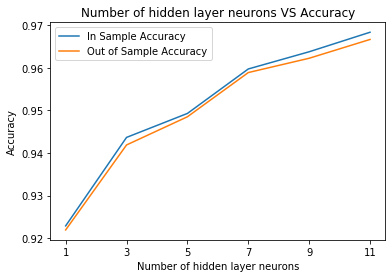

In [101]:
#Dataset 1 = sgemm product 
#==========================

n_node = [1,3,5,7,9,11]
a_train=[]
a_test=[]

for i in n_node:
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 1,2, 1, len(sgemm_train_x.columns),'relu','sigmoid',i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(n_node)))
plt.title("Number of hidden layer neurons VS Accuracy")
plt.xlabel("Number of hidden layer neurons")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,n_node)
plt.legend()
plt.show()

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 1
In sample confusion matrix:
[[1489    0]
 [  29 1325]]
Out of sample confusion matrix:
[[638   0]
 [ 12 569]]
2843/2843 [==============================] - 0s 22us/step
In Sample Accuracy: 0.99
1219/1219 [==============================] - 0s 20us/step
Out of Sample Accuracy: 0.99
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 1
In sample confusion matrix:
[[1447    0]
 [  28 1368]]
Out of sample confusion matrix:
[[634   0]
 [ 11 574]]
2843/2843 [==============================] - 0s 24us/step
In Sample Accuracy: 0.99
1219/1219 [==============================] - 0s 19us/step
Out of Sample Accuracy: 0.99
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 10
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
2843/2843 [==============================] - 0s 29us/step
In Sample Accuracy: 1.00
1219/1219 [==============================]

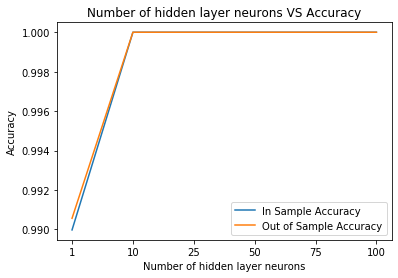

In [102]:
#Dataset 2 = mushroom 
#=====================

n_node = [1,10,25,50,75,100]
a_train=[]
a_test=[]

for i in n_node:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 1,2, 1, len(mush_train_x.columns),'relu','sigmoid',i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(n_node)))
plt.title("Number of hidden layer neurons VS Accuracy")
plt.xlabel("Number of hidden layer neurons")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,n_node)
plt.legend()
plt.show()

## Experiment with number of hidden layers

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[56982  1469]
 [ 1127 23144]]
Out of sample confusion matrix:
[[24402   660]
 [  510  9880]]
82722/82722 [==============================] - 1s 15us/step
In Sample Accuracy: 0.97
35452/35452 [==============================] - 1s 15us/step
Out of Sample Accuracy: 0.97
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[57171  1260]
 [ 1369 22922]]
Out of sample confusion matrix:
[[24412   576]
 [  625  9840]]
82722/82722 [==============================] - 1s 15us/step
In Sample Accuracy: 0.97
35453/35453 [==============================] - 1s 15us/step
Out of Sample Accuracy: 0.97
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
No.of neurons in hidden layer 2: 9
No.of neurons in hidden layer 3: 7
In sample confusion matrix:
[[56608  1843]
 [  613 23658]]
Out of sample confusion matrix:
[[24266   796]
 [  258 10132]]
82722/827

No.of neurons in hidden layer 7: 5
No.of neurons in hidden layer 8: 5
No.of neurons in hidden layer 9: 5
No.of neurons in hidden layer 10: 5
No.of neurons in hidden layer 11: 5
No.of neurons in hidden layer 12: 5
No.of neurons in hidden layer 13: 5
No.of neurons in hidden layer 14: 5
No.of neurons in hidden layer 15: 5
In sample confusion matrix:
[[57008  1443]
 [  522 23749]]
Out of sample confusion matrix:
[[24465   597]
 [  222 10168]]
82722/82722 [==============================] - 2s 26us/step
In Sample Accuracy: 0.98
35452/35452 [==============================] - 1s 22us/step
Out of Sample Accuracy: 0.98
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 11
No.of neurons in hidden layer 2: 9
No.of neurons in hidden layer 3: 7
No.of neurons in hidden layer 4: 6
No.of neurons in hidden layer 5: 5
No.of neurons in hidden layer 6: 5
No.of neurons in hidden layer 7: 5
No.of neurons in hidden layer 8: 5
No.of neurons in hidden layer 9: 5
No.of neurons in hidden layer 10: 

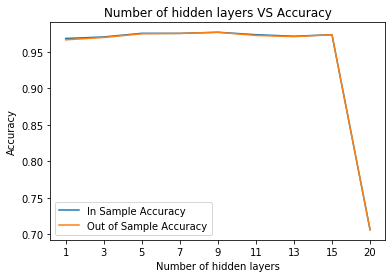

In [108]:
#Dataset 1 = sgemm product 
#==========================

n_layer = [1,3,5,7,9,11,13,15,20]
a_train=[]
a_test=[]

for i in n_layer:
                                                                                                         
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 1,2, i, len(sgemm_train_x.columns),'relu','sigmoid')
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(n_layer)))
plt.title("Number of hidden layers VS Accuracy")
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,n_layer)
plt.legend()
plt.show()

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
2843/2843 [==============================] - 0s 29us/step
In Sample Accuracy: 1.00
1219/1219 [==============================] - 0s 23us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[1447    0]
 [   0 1396]]
Out of sample confusion matrix:
[[634   0]
 [  0 585]]
2843/2843 [==============================] - 0s 25us/step
In Sample Accuracy: 1.00
1219/1219 [==============================] - 0s 20us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
No.of neurons in hidden layer 2: 51
No.of neurons in hidden layer 3: 35
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
2843/2843 [==============================] - 0s 29u

In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
2843/2843 [==============================] - 0s 38us/step
In Sample Accuracy: 1.00
1219/1219 [==============================] - 0s 21us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 75
No.of neurons in hidden layer 2: 51
No.of neurons in hidden layer 3: 35
No.of neurons in hidden layer 4: 25
No.of neurons in hidden layer 5: 18
No.of neurons in hidden layer 6: 13
No.of neurons in hidden layer 7: 10
No.of neurons in hidden layer 8: 8
No.of neurons in hidden layer 9: 7
No.of neurons in hidden layer 10: 6
No.of neurons in hidden layer 11: 5
No.of neurons in hidden layer 12: 5
No.of neurons in hidden layer 13: 5
No.of neurons in hidden layer 14: 5
No.of neurons in hidden layer 15: 5
In sample confusion matrix:
[[1447    0]
 [1396    0]]
Out of sample confusion matrix:
[[634   0]
 [585   0]]
2843/2843 [============================

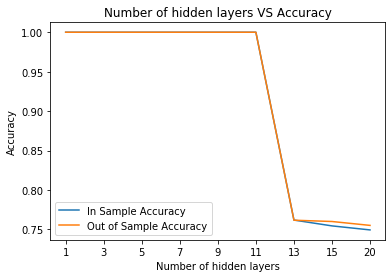

In [107]:
#Dataset 2 = mushroom 
#=====================

n_layer = [1,3,5,7,9,11,13,15,20]
a_train=[]
a_test=[]

for i in n_layer:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 1,2, i, len(mush_train_x.columns),'relu','sigmoid')
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(n_layer)))
plt.title("Number of hidden layers VS Accuracy")
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,n_layer)
plt.legend()
plt.show()

## Experiment with activation functions

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[57525   926]
 [ 1703 22568]]
Out of sample confusion matrix:
[[24660   402]
 [  726  9664]]
82722/82722 [==============================] - 1s 16us/step
In Sample Accuracy: 0.97
35452/35452 [==============================] - 1s 15us/step
Out of Sample Accuracy: 0.97
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[57150  1281]
 [ 1459 22832]]
Out of sample confusion matrix:
[[24421   567]
 [  648  9817]]
82722/82722 [==============================] - 2s 21us/step
In Sample Accuracy: 0.97
35453/35453 [==============================] - 1s 23us/step
Out of Sample Accuracy: 0.97
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[56468  1983]
 [ 1178 23093]]
Out of sample confusion matrix:
[[24182   880]
 [  495  9895]]
82722/82722 [==============================] - 1s 17us/step
In Sample Accuracy:

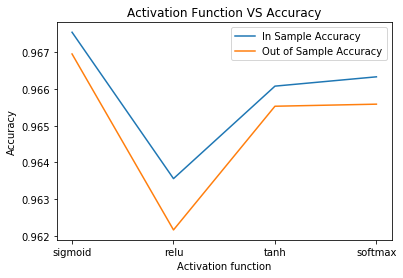

In [109]:
#Dataset 1 = sgemm product 
#==========================

act = ['sigmoid','relu','tanh','softmax']
a_train=[]
a_test=[]

for i in act:                                                                                                         
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 1,2, 1, len(sgemm_train_x.columns),i,i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(act)))
plt.title("Activation Function VS Accuracy")
plt.xlabel("Activation function")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,act)
plt.legend()
plt.show()

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
2843/2843 [==============================] - 0s 27us/step
In Sample Accuracy: 1.00
1219/1219 [==============================] - 0s 24us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[1447    0]
 [   0 1396]]
Out of sample confusion matrix:
[[634   0]
 [  0 585]]
2843/2843 [==============================] - 0s 28us/step
In Sample Accuracy: 1.00
1219/1219 [==============================] - 0s 27us/step
Out of Sample Accuracy: 1.00
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
2843/2843 [==============================] - 0s 26us/step
In Sample Accuracy: 1.00
1219/1219 [=============================

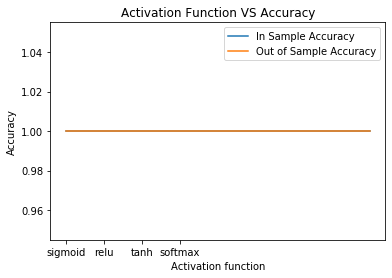

In [110]:
#Dataset 2 = mushroom 
#=====================

act = ['sigmoid','relu','tanh','softmax']
a_train=[]
a_test=[]

for i in n_layer:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 1,2, 1, len(mush_train_x.columns),i,i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(act)))
plt.title("Activation Function VS Accuracy")
plt.xlabel("Activation function")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,act)
plt.legend()
plt.show()

## Experiment with sample size

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[33  1]
 [ 9  7]]
Out of sample confusion matrix:
[[38  0]
 [ 8  4]]
50/50 [==============================] - 0s 598us/step
In Sample Accuracy: 0.80
50/50 [==============================] - 0s 80us/step
Out of Sample Accuracy: 0.84
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[33  4]
 [ 4  9]]
Out of sample confusion matrix:
[[27  4]
 [ 7 12]]
50/50 [==============================] - 0s 379us/step
In Sample Accuracy: 0.84
50/50 [==============================] - 0s 80us/step
Out of Sample Accuracy: 0.78
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[340  14]
 [ 33 113]]
Out of sample confusion matrix:
[[335  15]
 [ 29 121]]
500/500 [==============================] - 0s 50us/step
In Sample Accuracy: 0.91
500/500 [==============================] - 0s 22us/step
Out of Sample Accuracy: 0.91

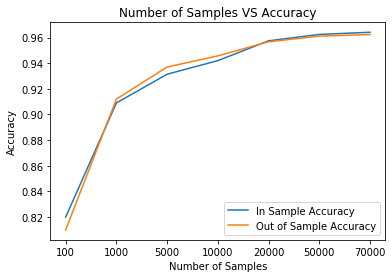

In [111]:
# Dataset 1 = sgemm product 
#===========================

fold = [100,1000,5000,10000,20000,50000,70000]
a_train=[]
a_test=[]

for i in fold:
    acc_train, acc_test = cross_validation(sgemm_train_x.head(i), sgemm_train_y.head(i), sgemm_test_x.head(i), sgemm_test_y.head(i), 1,2, 1, len(sgemm_train_x.columns),'relu','sigmoid')
    a_train.append(statistics.mean(acc_train))
    a_test.append(statistics.mean(acc_test))
print(a_train)
print(a_test)

xi = list(range(len(fold)))
plt.title("Number of Samples VS Accuracy")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,fold)
plt.legend()
plt.show()

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[28  0]
 [ 3 19]]
Out of sample confusion matrix:
[[21  0]
 [10 19]]
50/50 [==============================] - 0s 399us/step
In Sample Accuracy: 0.94
50/50 [==============================] - 0s 60us/step
Out of Sample Accuracy: 0.80
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[24  0]
 [ 2 24]]
Out of sample confusion matrix:
[[28  1]
 [ 2 19]]
50/50 [==============================] - 0s 339us/step
In Sample Accuracy: 0.96
50/50 [==============================] - 0s 60us/step
Out of Sample Accuracy: 0.94
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[138   1]
 [  1 110]]
Out of sample confusion matrix:
[[132   0]
 [  1 117]]
250/250 [==============================] - 0s 92us/step
In Sample Accuracy: 0.99
250/250 [==============================] - 0s 32us/step
Out of Sample Accuracy: 1.00

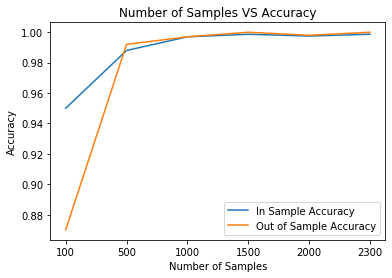

In [112]:
# Dataset 2 = mushroom 
#===========================

fold = [100,500,1000,1500,2000,2300]
a_train=[]
a_test=[]

for i in fold:
    acc_train, acc_test = cross_validation(mush_train_x.head(i), mush_train_y.head(i), mush_test_x.head(i), mush_test_y.head(i), 1,2, 1, len(mush_train_x.columns),'relu','sigmoid')
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(fold)))
plt.title("Number of Samples VS Accuracy")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,fold)
plt.legend()
plt.show()

In [23]:
model = KerasClassifier(build_fn = perf_tune_sgemm)
epochs=[50,100]
batch_size = [10, 20, 40, 60, 80, 100]
optimizer = ['SGD', 'RMSprop','Adam']
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']

param_grid = dict(epochs=epochs,batch_size=batch_size,optimizer=optimizer,activation=activation)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=1, n_iter=2, cv=KFold(2))
# GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(sgemm_train_x, sgemm_train_y, verbose=0)

print(grid_result.best_score_)
print(grid_result.best_params_)


82722/82722 [==============================] - 1s 15us/step
0.9688595533370972
{'optimizer': 'RMSprop', 'epochs': 100, 'batch_size': 40, 'activation': 'sigmoid'}


In [32]:
model = KerasClassifier(build_fn = perf_tune_mush)
epochs=[50,100]
batch_size = [10, 20, 40, 60, 80, 100]
optimizer = ['SGD', 'RMSprop', 'Adam']
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']

param_grid = dict(epochs=epochs,batch_size=batch_size,optimizer=optimizer,activation=activation)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=1, n_iter=2, cv=KFold(2))
# GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(mush_train_x, mush_train_y, verbose=0)

print(grid_result.best_score_)
print(grid_result.best_params_)

2843/2843 [==============================] - 0s 26us/step
1.0
{'optimizer': 'Adam', 'epochs': 50, 'batch_size': 10, 'activation': 'softmax'}


# K - Nearest Neighbors

In [36]:
#Dataset 1 = sgemm product 
#==========================

acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 2,4, neighbor=3 )


print("In Sample accuracy from KNN is {0}".format(acc_train))
print("Out of Sample accuracy from KNN is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from KNN is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from KNN is {0}".format(statistics.mean(acc_test)))

Cross validation iteration : 1
In sample confusion matrix:
[[27987  1150]
 [ 1385 10839]]
Out of sample confusion matrix:
[[12013   470]
 [  550  4693]]
In Sample Accuracy: 0.94
Out of Sample Accuracy: 0.94
Cross validation iteration : 2
In sample confusion matrix:
[[28132  1182]
 [ 1326 10721]]
Out of sample confusion matrix:
[[12060   519]
 [  522  4625]]
In Sample Accuracy: 0.94
Out of Sample Accuracy: 0.94
Cross validation iteration : 3
In sample confusion matrix:
[[28045  1115]
 [ 1314 10887]]
Out of sample confusion matrix:
[[12006   496]
 [  573  4651]]
In Sample Accuracy: 0.94
Out of Sample Accuracy: 0.94
Cross validation iteration : 4
In sample confusion matrix:
[[28142  1129]
 [ 1328 10762]]
Out of sample confusion matrix:
[[11969   517]
 [  585  4656]]
In Sample Accuracy: 0.94
Out of Sample Accuracy: 0.94
In Sample accuracy from KNN is [0.9387103793428592, 0.9393631682019293, 0.9412731800488383, 0.9405962138246174]
Out of Sample accuracy from KNN is [0.9424574071984655, 0.94

In [30]:
# Dataset 2 = mushroom
#======================

acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 2,4, neighbor=3)

print("In Sample accuracy from KNN is {0}".format(acc_train))
print("Out of Sample accuracy from KNN is {0}".format(acc_test))
print(" ")
print("Average In Sample accuracy from KNN is {0}".format(statistics.mean(acc_train)))
print("Average Out of Sample accuracy from KNN is {0}".format(statistics.mean(acc_test)))

Cross validation iteration : 1
In sample confusion matrix:
[[734   0]
 [  0 687]]
Out of sample confusion matrix:
[[319   0]
 [  0 290]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
In sample confusion matrix:
[[755   0]
 [  0 667]]
Out of sample confusion matrix:
[[319   0]
 [  0 291]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 3
In sample confusion matrix:
[[705   0]
 [  0 716]]
Out of sample confusion matrix:
[[318   0]
 [  0 291]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 4
In sample confusion matrix:
[[742   0]
 [  0 680]]
Out of sample confusion matrix:
[[316   0]
 [  0 294]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
In Sample accuracy from KNN is [1.0, 1.0, 1.0, 1.0]
Out of Sample accuracy from KNN is [1.0, 1.0, 1.0, 1.0]
 
Average In Sample accuracy from KNN is 1.0
Average Out of Sample accuracy from KNN is 1.0


## Experiment with different neighbors

Cross validation iteration : 1
In sample confusion matrix:
[[54999  3452]
 [ 3700 20571]]
Out of sample confusion matrix:
[[23511  1551]
 [ 1519  8871]]
In Sample Accuracy: 0.91
Out of Sample Accuracy: 0.91
Cross validation iteration : 2
In sample confusion matrix:
[[55030  3401]
 [ 3633 20658]]
Out of sample confusion matrix:
[[23427  1561]
 [ 1588  8877]]
In Sample Accuracy: 0.91
Out of Sample Accuracy: 0.91
Cross validation iteration : 1
In sample confusion matrix:
[[55973  2478]
 [ 2952 21319]]
Out of sample confusion matrix:
[[23987  1075]
 [ 1199  9191]]
In Sample Accuracy: 0.93
Out of Sample Accuracy: 0.94
Cross validation iteration : 2
In sample confusion matrix:
[[55948  2483]
 [ 2922 21369]]
Out of sample confusion matrix:
[[23868  1120]
 [ 1199  9266]]
In Sample Accuracy: 0.93
Out of Sample Accuracy: 0.93
Cross validation iteration : 1
In sample confusion matrix:
[[56318  2133]
 [ 2635 21636]]
Out of sample confusion matrix:
[[24165   897]
 [ 1082  9308]]
In Sample Accuracy:

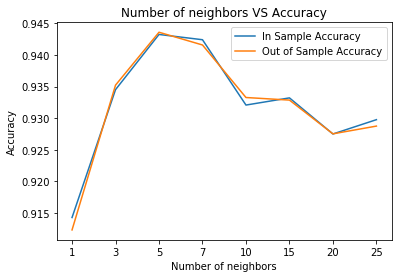

In [31]:
#Dataset 1 = sgemm product 
#==========================

n_neighbor = [1,3,5,7,10,15,20,25]
a_train=[]
a_test=[]

for i in n_neighbor:                                                                                                         
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 2,2, neighbor=i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(n_neighbor)))
plt.title("Number of neighbors VS Accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,n_neighbor)
plt.legend()
plt.show()

Cross validation iteration : 1
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
In sample confusion matrix:
[[1447    0]
 [   0 1396]]
Out of sample confusion matrix:
[[634   0]
 [  0 585]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 1
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
In sample confusion matrix:
[[1447    0]
 [   0 1396]]
Out of sample confusion matrix:
[[634   0]
 [  0 585]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 1
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteratio

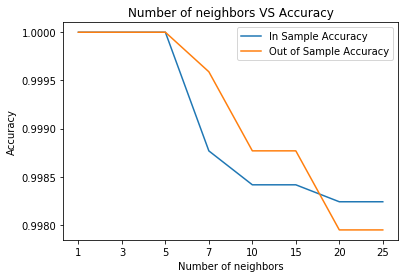

In [32]:
#Dataset 2 = mushroom 
#=====================

n_neighbor = [1,3,5,7,10,15,20,25]
a_train=[]
a_test=[]

for i in n_neighbor:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 2,2,neighbor=i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(n_neighbor)))
plt.title("Number of neighbors VS Accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,n_neighbor)
plt.legend()
plt.show()

## Experiment with different distance metrics

Cross validation iteration : 1
In sample confusion matrix:
[[56318  2133]
 [ 2635 21636]]
Out of sample confusion matrix:
[[24165   897]
 [ 1082  9308]]
In Sample Accuracy: 0.94
Out of Sample Accuracy: 0.94
Cross validation iteration : 2
In sample confusion matrix:
[[56316  2115]
 [ 2506 21785]]
Out of sample confusion matrix:
[[24059   929]
 [ 1091  9374]]
In Sample Accuracy: 0.94
Out of Sample Accuracy: 0.94
Cross validation iteration : 1
In sample confusion matrix:
[[56745  1706]
 [ 2515 21756]]
Out of sample confusion matrix:
[[24369   693]
 [  999  9391]]
In Sample Accuracy: 0.95
Out of Sample Accuracy: 0.95
Cross validation iteration : 2
In sample confusion matrix:
[[56775  1656]
 [ 2415 21876]]
Out of sample confusion matrix:
[[24229   759]
 [ 1072  9393]]
In Sample Accuracy: 0.95
Out of Sample Accuracy: 0.95
Cross validation iteration : 1
In sample confusion matrix:
[[54737  3714]
 [ 6376 17895]]
Out of sample confusion matrix:
[[23491  1571]
 [ 2653  7737]]
In Sample Accuracy:

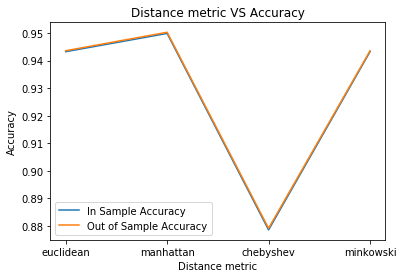

In [38]:
#Dataset 1 = sgemm product 
#==========================

dist = ['euclidean','manhattan','chebyshev','minkowski']
a_train=[]
a_test=[]

for i in dist:                                                                                                         
    acc_train, acc_test = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, 2,2, neighbor=5, dist_metric=i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(dist)))
plt.title("Distance metric VS Accuracy")
plt.xlabel("Distance metric")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,dist)
plt.legend()
plt.show()

Cross validation iteration : 1
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
In sample confusion matrix:
[[1447    0]
 [   0 1396]]
Out of sample confusion matrix:
[[634   0]
 [  0 585]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 1
In sample confusion matrix:
[[1489    0]
 [   0 1354]]
Out of sample confusion matrix:
[[638   0]
 [  0 581]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 2
In sample confusion matrix:
[[1447    0]
 [   0 1396]]
Out of sample confusion matrix:
[[634   0]
 [  0 585]]
In Sample Accuracy: 1.00
Out of Sample Accuracy: 1.00
Cross validation iteration : 1
In sample confusion matrix:
[[1084  405]
 [ 437  917]]
Out of sample confusion matrix:
[[461 177]
 [178 403]]
In Sample Accuracy: 0.70
Out of Sample Accuracy: 0.71
Cross validation iteratio

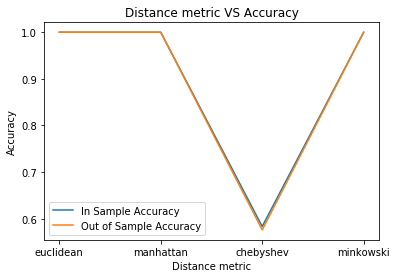

In [39]:
#Dataset 2 = mushroom 
#=====================

dist = ['euclidean','manhattan','chebyshev','minkowski']
a_train=[]
a_test=[]

for i in dist:
    acc_train, acc_test = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_test_y, 2,2, neighbor=5, dist_metric=i)
    mean_a_train = statistics.mean(acc_train)
    mean_a_test = statistics.mean(acc_test)
    a_train.append(mean_a_train)
    a_test.append(mean_a_test)
print(a_train) 
print(a_test)

xi = list(range(len(dist)))
plt.title("Distance metric VS Accuracy")
plt.xlabel("Distance metric")
plt.ylabel("Accuracy")
plt.plot(a_train, label = 'In Sample Accuracy')
plt.plot(a_test, label = 'Out of Sample Accuracy')
plt.xticks(xi,dist)
plt.legend()
plt.show()